In [39]:
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import operator
import random
import matplotlib.pyplot as plt

In [40]:
class User(object):
    def __init__(self, user_id):
        self.id = user_id
        self.artist_weight = {}
        self.tags = {}
        self.artist_tag = {}
        self.friends = []
        self.expert_score = 0
        self.group_number = 0
        
        
        ## for test purpose
        self.hidden_artist_weight = {}
        self.unhidden_artist_weight = {}
        
    def add_artist_weight(self, artist_id, weight):
        self.artist_weight[artist_id] = weight
        
    def add_artist_tag(self, artist_id, tag):
        #Record tags that the user tagged
        if tag in self.tags:
            self.tags[tag] += 1
        else:
            self.tags[tag] = 1
            
        #Record artists that user tagged
        if artist_id in self.artist_tag:
            self.artist_tag[artist_id] += 1
        else:
            self.artist_tag[artist_id] = 1
            
        #Record number of tags that user tagged
        self.expert_score += 1
    
    def add_friend(self, user):
        self.friends.append(user)
    
    def get_artist_weight(self):
        return self.artist_weight
    
    #For test purpose
    
    def hide_some_artists(self):
        self.hidden_artist_weight = {}
        artists = np.random.choice(list(self.artist_weight), int(len(self.artist_weight)*0.1), replace=False)
        for artist in artists:
            self.hidden_artist_weight[artist] = self.artist_weight[artist]
   
    def get_unhidden_artists(self):
        self.unhidden_artist_weight = {}
        for key in self.artist_weight.keys():
            if key not in self.hidden_artist_weight:
                self.unhidden_artist_weight[key] = self.artist_weight[key]
        return self.unhidden_artist_weight
            
    def get_hidden_artists(self):
        return self.hidden_artist_weight
        
    
class Artist(object):
    def __init__(self, artist_id):
        self.id = artist_id
        self.tag_count = {}
        self.listened_times = 0  #Can express popularity
    
    def add_weight(self, weight):
        self.listened_times += weight
    def add_tag (self, tag):
        if tag in self.tag_count:
            self.tag_count[tag] += 1
        else:
            self.tag_count[tag] = 1


**Load data**

In [41]:
def prepareData():
    '''Read data from the files and store the data in the object member variables'''
    '''Returns dictionaries of users and artists'''
    
    users = {}    #Key: userId, Value: User object
    artists = {}  #Key: artistId, Value: Artist object
    
    user_artists = pd.read_csv("user_artists.dat", sep='\t', skiprows=0)
    #print(user_artists.head())
    
    user_tag = pd.read_csv("user_taggedartists.dat", sep='\t', skiprows=0)
    #print(user_tag.head())
    
    user_friends = pd.read_csv("user_friends.dat", sep='\t', skiprows=0)
    #print(user_friends.head())
    
    
    # Create User and Artist objects and populate member variables
    
    # Add artist and weight into User
    
    for index, row in user_artists.iterrows():
        if row['userID'] not in users:  
            user = User(row['userID'])
            users[row['userID']] = user
        else:
            user = users[row['userID'] ]
        user.add_artist_weight(row['artistID'], row['weight'])
    
    # Add weight into Artist

        if row['artistID'] not in artists:
            artist = Artist(row['artistID'])
            artists[row['artistID']] = artist
        else:
            artist = artists[row['artistID']] 
        artist.add_weight(row['weight'])
                  
    
    # Add artist and tag into User
    
    for index, row in user_tag.iterrows():
        if row['userID']  not in users:
            print("Unknown user!!")
        else:
            user = users[row['userID'] ]
            user.add_artist_tag(row['artistID'], row['tagID'])
    
    # Add tag into Artist
    
        if row['artistID'] not in artists:
            # Artists were tagged by a user even it is not in user_artist.dat
            #print("Unknown artist: ", row['artistID'])
            artist = Artist(row['artistID'])
            artists[row['artistID']] = artist
        else:
            artist = artists[row['artistID']] 
        artist.add_tag(row['tagID'])
    
    #Add friends into User
    
    for index, row in user_friends.iterrows():
        if row['userID']  not in users:
            print("Unknown user!!")
        else:
            user = users[row['userID'] ]
            friend = users[row['friendID']]
            user.add_friend(friend)
    return(users, artists)

In [42]:
users, artists = prepareData()
print("Number of users: ", len(users))
print("Number of artists: ", len(artists))

Number of users:  1892
Number of artists:  18022


**Extract features**

In [43]:
def extractFeatures(users, artists, testUserId):
    '''Create features '''
    '''Returns sparse np array of features'''
    
    artistTags = np.zeros((18746, 12648))
    for artId in artists.keys():
        for tagId in (artists[artId].tag_count.keys()):
            artistTags[artId][tagId] = artists[artId].tag_count[tagId]

    userArtists = np.zeros((2101, 18746))
    userGenres = np.zeros((2101, 12648))

    for userId in users.keys():
        if userId not in testUserId:
            for artId in (users[userId].artist_weight.keys()):
                userArtists[userId][artId] = users[userId].artist_weight[artId]
            
            for tagId in (users[userId].tags.keys()):
                userGenres[userId][tagId] = users[userId].tags[tagId]
        
        if userId in testUserId:
            #Hide some artists in training
            users[userId].hide_some_artists()
            unhidden_artists = users[userId].get_unhidden_artists()
            
            for artist in unhidden_artists.keys():
                userArtists[userId][artist] = unhidden_artists[artist]
            
    
    userArtists = normalize((userArtists))
    artistTags = normalize((artistTags))
    userGenres = normalize((userGenres))
    
    return userArtists, artistTags, userGenres

**Build a model**

In [44]:
testSize = 0.2

targetTestSize = int(len(users)*testSize)
print("Number of test users: ", targetTestSize)

test_users = np.random.choice((range(0, 2101)), targetTestSize, replace=False)
    

userArtists, artistTags, userGenres = extractFeatures(users, artists, test_users)

'''Group users using K-Means Clustering'''
'''We should choose n_clusters that gives us the best result'''
kmeans = KMeans(n_clusters=10, random_state=0).fit(userArtists)     

Number of test users:  378


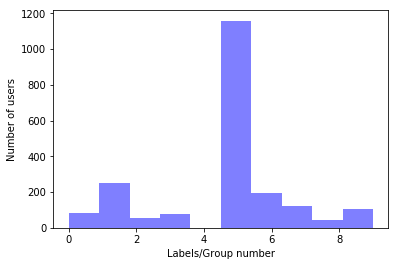

In [45]:
plt.hist(kmeans.labels_, 10, facecolor='blue', alpha=0.5)
plt.xlabel('Labels/Group number')
plt.ylabel('Number of users')
plt.show()

**Predict**

In [46]:
def calculateSimilariy(data):
    #Calculate similarities between users based on their euclidean distances
    #Input userArtists space array
    distance = euclidean_distances(data, data)   
    return distance

def assignGroup(users, labels):    
    #Assign each user's group
    for i in range(len(labels)):
        if i in users:
            users[i].group_number = labels[i]

def findGroupExpert(users, test_users):
    #Find an expert in each group
    
    group_expert = {}
    
    for userId in users.keys():
        if userId in test_users:
            continue
        if users[userId].group_number in group_expert:
            if (group_expert[users[userId].group_number].expert_score < users[userId].expert_score):
                group_expert[users[userId].group_number] = users[userId]
        else:
            group_expert[users[userId].group_number] = users[userId]
    return group_expert

def recommend(user, groupExpert):
    experts_artist_weight = groupExpert[user.group_number].get_artist_weight()
    sorted_experts_artist_weight = sorted(experts_artist_weight.items(), key=operator.itemgetter(1))
   # return (sorted_experts_artist_weight[-10:])
    return (sorted_experts_artist_weight)

In [47]:
assignGroup(users, kmeans.labels_)
group_expert = findGroupExpert(users, test_users)
print("Group ExpertScore")
for keys in group_expert:
    print("%5d%8d" %(group_expert[keys].group_number, group_expert[keys].expert_score))

Group ExpertScore
    0    2609
    6    2075
    5    1876
    1    1687
    9     564
    2     678
    7    2024
    8    1500
    3    1137
    4      50


In [48]:
result = 0
all_results = 0
user_count = 0

for index in test_users:
    if index not in users:
        continue
        
    rec_list = recommend(users[index], group_expert)
    users_artist = users[index].get_hidden_artists()
    
    if (len(users_artist) == 0):
        continue
        
    hit = 0
    for rec in rec_list:
        if rec[0] in users_artist:
            hit += 1
    print("hit", hit,  rec_list,users_artist )
    result = hit/len(users_artist)
    print(result)
    all_results += result
    user_count += 1   #Since some of the index don't exist

coverage = all_results/user_count    
print("Average coverage: ", coverage)

hit 1 [(331, 373), (3317, 387), (229, 390), (2051, 393), (204, 406), (4619, 413), (518, 414), (1243, 463), (1934, 467), (701, 472), (333, 487), (1507, 488), (230, 503), (1980, 524), (344, 532), (3371, 561), (1613, 571), (691, 606), (228, 618), (475, 618), (220, 623), (2176, 644), (1055, 652), (289, 698), (3171, 729), (4618, 772), (154, 812), (314, 832), (234, 927), (1511, 1099), (468, 1102), (679, 1115), (300, 1134), (257, 1171), (329, 1201), (1376, 1217), (547, 1285), (89, 1435), (2526, 1575), (65, 1679), (191, 1721), (327, 1764), (301, 2309), (4617, 2444), (294, 2496), (292, 3477), (4616, 3542), (288, 4769), (190, 7774), (295, 9726)] {2788: 155, 190: 216, 1807: 89, 3125: 173, 302: 117}
0.2
hit 0 [(5424, 329), (1109, 330), (5423, 332), (5422, 334), (5421, 336), (196, 342), (5420, 342), (5419, 344), (622, 346), (3259, 357), (5418, 405), (5417, 409), (4793, 412), (1090, 418), (231, 419), (5416, 424), (5415, 426), (225, 427), (554, 433), (5414, 435), (3469, 472), (5413, 472), (5412, 518)

hit 0 [(599, 838), (2347, 838), (1014, 846), (2251, 846), (229, 849), (1814, 857), (2444, 862), (1017, 869), (3481, 878), (72, 908), (316, 930), (193, 937), (1298, 975), (475, 978), (1886, 980), (2030, 986), (17652, 1013), (706, 1020), (1203, 1031), (1513, 1060), (17616, 1086), (1343, 1089), (1001, 1098), (864, 1118), (1890, 1126), (1413, 1146), (1358, 1149), (4126, 1166), (12733, 1206), (2531, 1221), (1705, 1241), (1463, 1258), (917, 1282), (910, 1336), (857, 1421), (3289, 1431), (89, 1480), (959, 1502), (4255, 1533), (3988, 1927), (163, 2052), (3769, 2064), (8422, 2069), (173, 2111), (1110, 2197), (5175, 2262), (2044, 2344), (877, 2431), (3264, 2516), (2236, 3112)] {52: 15, 11894: 12, 429: 2, 8680: 2, 11900: 2}
0.0
hit 1 [(13345, 99), (15993, 99), (416, 104), (428, 105), (3280, 105), (3371, 106), (13167, 106), (208, 114), (1072, 118), (1098, 118), (5913, 119), (7324, 127), (533, 129), (6374, 131), (15992, 132), (863, 137), (875, 146), (5879, 149), (1097, 150), (14435, 156), (212, 157

In [49]:
coverage

0.09980039920159671